Accuracy: 0.808165548098434

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.82      0.89      3403
           1       0.15      0.62      0.24       173

    accuracy                           0.81      3576
   macro avg       0.56      0.72      0.56      3576
weighted avg       0.94      0.81      0.86      3576



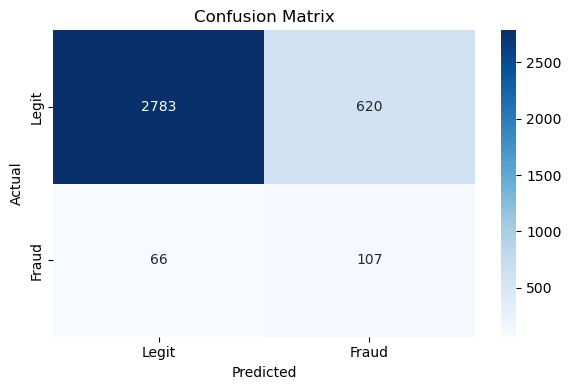

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the dataset
df = pd.read_csv("fake_job_postings.csv", encoding='ISO-8859-1')

# Step 2: Drop unnecessary columns
columns_to_drop = ['job_id', 'title', 'location', 'company_profile', 'description',
                   'requirements', 'benefits', 'employment_type', 'required_education',
                   'industry', 'function', 'department']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

# Step 3: Drop rows with missing target
df = df.dropna(subset=['fraudulent'])

# Step 4: Fill missing values
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].fillna('Unknown')

# Step 5: Encode categorical variables
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Step 6: Split data
X = df.drop("fraudulent", axis=1)
y = df["fraudulent"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Step 7: Train logistic regression
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

# Step 8: Predict and evaluate
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Step 9: Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Legit", "Fraud"], yticklabels=["Legit", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [2]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

st.set_page_config(page_title="Live Job Fraud Detector", layout="wide")

st.title("🕵️‍♂️ Job Posting Fraud Detection")
st.markdown("Paste any job description to predict if it's **fraudulent** or **legitimate**. Data insights update as you type!")

# Load and train model
@st.cache_data
def load_model():
    df = pd.read_csv("fake_job_postings.csv", encoding='ISO-8859-1')
    df['text'] = df['description'].fillna('') + ' ' + df['requirements'].fillna('') + ' ' + df['benefits'].fillna('')
    df = df[['text', 'fraudulent']].dropna()
    
    tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
    X = tfidf.fit_transform(df['text'])
    y = df['fraudulent']

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    model = LogisticRegression(max_iter=1000, class_weight='balanced')
    model.fit(X_train, y_train)

    return model, tfidf, X_test, y_test, model.predict(X_test)

model, tfidf, X_test, y_test, y_pred = load_model()

# ---- Sidebar: Data Insights ----
st.sidebar.title("📊 Data Insights")

# ---- User input ----
user_input = st.text_area("Paste Job Posting Text Below", height=300)

def clean_text(text):
    text = re.sub(r"[^A-Za-z0-9 ]", "", text.lower())
    return text

def extract_keywords(text, top_n=5):
    words = clean_text(text).split()
    stopwords = set(tfidf.get_stop_words() or [])
    words = [word for word in words if word not in stopwords]
    return Counter(words).most_common(top_n)

if user_input.strip():
    # Sidebar insights
    word_count = len(user_input.split())
    st.sidebar.markdown(f"**📝 Word Count:** {word_count}")

    # Extract top words
    top_words = extract_keywords(user_input)
    st.sidebar.markdown("**🔥 Top Keywords:**")
    for word, count in top_words:
        st.sidebar.write(f"• {word} ({count}x)")

    # Spammy keywords (simple examples)
    spammy_words = ['congratulations', 'earn', 'click', 'limited', 'urgent', 'guaranteed', 'fee']
    found_spam = [word for word in spammy_words if word in clean_text(user_input)]
    if found_spam:
        st.sidebar.markdown("**⚠️ Trigger Words:**")
        for word in found_spam:
            st.sidebar.write(f"• `{word}`")
    else:
        st.sidebar.markdown("**✅ No spammy words detected.**")

    # ---- Predict fraud ----
    input_vec = tfidf.transform([user_input])
    pred = model.predict(input_vec)[0]
    prob = model.predict_proba(input_vec)[0][pred]
    label = "🚨 Fraudulent" if pred == 1 else "✅ Legitimate"

    st.subheader("🔍 Prediction")
    st.markdown(f"**Result**: {label}")
    st.markdown(f"**Confidence**: {prob:.2f}")

else:
    st.sidebar.markdown("Enter a job posting above to see insights.")

# ---- Model performance ----
with st.expander("📈 Show Model Evaluation"):
    acc = accuracy_score(y_test, y_pred)
    st.write(f"**Accuracy:** {acc:.2f}")
    st.text("Classification Report:")
    st.text(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=["Legit", "Fraud"], yticklabels=["Legit", "Fraud"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    st.pyplot(fig)



Overwriting app.py


In [ ]:
!streamlit run app.py